In [1]:
import os
import ijson
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ISCLEAN = False
data_file_name = 'yellow_tripdata_2021-01_raw_updated.csv'
surcharge_data_file_name = 'surcharge_data.json'
directory = 'input'
output_directory = 'output'
q1_output_filename = 'q1_average_tip.csv'
q2_output_filename = 'q2_busiest_time.csv'
q4_output_filename = 'q4_classify_trips.csv'
q5_output_filename = 'q5_correlation.csv'

In [3]:
# Constructing the paths
data_file_path = os.path.join(directory, data_file_name)
surcharge_data_file_path = os.path.join(directory, surcharge_data_file_name)
q1_output_path = os.path.join(output_directory, q1_output_filename)
q2_output_path = os.path.join(output_directory, q2_output_filename)
q4_output_path = os.path.join(output_directory, q4_output_filename)
q5_output_path = os.path.join(output_directory, q5_output_filename)

## Clean the Data and fix any anomalies

In [4]:
def km_to_miles(km):
    return km * 0.621371

# Function to check if the value includes 'km' and convert if necessary
def clean_trip_distance(value):
    if 'km' in value:
        # Extract the numeric part and convert from km to miles
        return km_to_miles(float(value.replace('km', '')))
    else:
        # Value is already in miles, return as is
        return float(value)

# Function to clean data and detect anomalies
def clean_data(data):
    
    # Missing total_amount
    # Drop rows with missing values
    data.dropna(inplace=True)

    # consider only 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
    data = data[data['VendorID'].isin([1.0, 2.0])]
    
    # RatecodeID restricted to be [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    data = data[data['RatecodeID'].isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])]

    # Restrict 'extra' column to values 0, 0.5, and 1.0
    # Find the closest value among 0, 0.5, and 1.0 for each value in 'extra'
    data['extra'] = data['extra'].apply(lambda x: min([0, 0.5, 1.0], key=lambda y: abs(x-y)))
    
    # Transform 'tip_amount' & 'Tolls_amount' to get absolute values
    data['tip_amount'] = data['tip_amount'].abs()
    data['tolls_amount'] = data['tolls_amount'].abs()
    
    # Convert 'tpep_dropoff_datetime' & 'tpep_pickup_datetime' to datetime format if it's not already
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])

    # Filter the DataFrame to include only rows where 'tpep_dropoff_datetime' & 'tpep_pickup_datetime' is between January 1, 2021, and January 31, 2021
    data = data[(data['tpep_dropoff_datetime'] >= '2021-01-01') & (data['tpep_dropoff_datetime'] <= '2021-01-31')]
    data = data[(data['tpep_pickup_datetime'] >= '2021-01-01') & (data['tpep_pickup_datetime'] <= '2021-01-31')]

    # Apply the cleaning function to the 'trip_distance' column
    data['trip_distance'] = data['trip_distance'].apply(clean_trip_distance)
    return data

In [5]:

def extract_data(data_file_path, clean=False):
    # Read the CSV file in chunks
    chunksize = 10 ** 6  # Adjust based on your system's memory
    chunks = []

    for chunk in pd.read_csv(data_file_path, chunksize=chunksize):
        # Clean each chunk of data
        # Simple cleaning has reduced (1369765, 16) to (1150638, 16)
        chunks.append(clean_data(chunk) if not clean else chunk)

    # Concatenate all chunks into a single DataFrame
    data = pd.concat(chunks, ignore_index=True)
    return data

In [6]:
trip_data_df = extract_data(data_file_path, ISCLEAN)

/var/folders/r2/rn453pm14l33hp9shz2yc03h0000gn/T/ipykernel_20779/344418727.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(data_file_path, chunksize=chunksize):


In [7]:
def read_surcharge_data_with_ijson(file_path, clean):
    # Initialize an empty list to store the data
    data = []
    
    # Open the file in read mode
    with open(file_path, 'r') as file:
        # Create an ijson object
        objects = ijson.kvitems(file, '')
        # Iterate over each object in the file
        for key, value in objects:
            # Create a dictionary with 'tripId', 'improvement_surcharge', and 'congestion_surcharge'
            row_data = {'tripId': key, 'improvement_surcharge': value['improvement_surcharge'], 'congestion_surcharge': value['congestion_surcharge']}
            
            # Append the row data to the list
            data.append(row_data)
    
    # Concatenate all the data into a single DataFrame
    df = pd.DataFrame(data)
    
    # Rename the columns as specified
    df.columns = ['tripId', 'improvement_surcharge', 'congestion_surcharge']
    
    # using dictionary to convert specific columns
    convert_dict = {'tripId': np.int64,
                    'improvement_surcharge': np.float64,
                    'congestion_surcharge': np.float64
                    }
    
    df = df.astype(convert_dict)
    if not clean:
        # Transform 'improvement_surcharge' & 'congestion_surcharge' to get absolute values
        df['improvement_surcharge'] = df['improvement_surcharge'].abs()
        df['congestion_surcharge'] = df['congestion_surcharge'].abs()
    
    
    return df

In [8]:
surcharge_df = read_surcharge_data_with_ijson(surcharge_data_file_path, clean = ISCLEAN)

## Average tip received by a vendor during the day
To find the average tip received by a vendor during the day, we have considered these reasonings and assumptions:

### Reasoning:
- **Filter by Time**: We're interested in daily averages, so we need to ensure that our calculations are based on daily groupings. Extracting the date from the datetime column allows us to group rides by the day they occurred.
- **Calculate Average Tip**: Finally, we calculate the mean of the `tip_amount` for each group. This gives us the average tip received by each vendor on each day.

This function provides a straightforward way to analyze tipping patterns for vendors on a daily basis, which can be useful for understanding vendor performance and customer behavior.

### Assumptions:
- Single Time Zone: The function assumes that all data is in the same time zone. If the dataset spans multiple time zones, the busiest hour might vary by location.
- Using `tpep_pickup_time` instead of `tpep_dropoff_datetime` for calculating the average tip received by a vendor during the day is based on the assumption that the tip is more closely associated with the pickup time rather than the dropoff time. Here are the reasons for this choice:
    1. **Immediate Feedback**
    2. **Consistency with Business Logic**
    3. **Simplification of Time Zone Issues**
    4. **Operational Reporting**
    5. **Data Integrity and Completeness**

In [9]:
def calculate_average_tip_per_day(data):
    # Convert 'tpep_pickup_datetime' to datetime and extract the date
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['pickup_date'] = data['tpep_pickup_datetime'].dt.date
    
    # Group by 'VendorID' and 'pickup_date', then calculate the average 'tip_amount'
    average_tip_per_day = data.groupby(['VendorID', 'pickup_date'])['tip_amount'].mean().reset_index()
    
    return average_tip_per_day

In [10]:
trip_data_df_copy = trip_data_df.copy()
average_tip_df = calculate_average_tip_per_day(trip_data_df_copy)
average_tip_df.to_csv(q1_output_path)

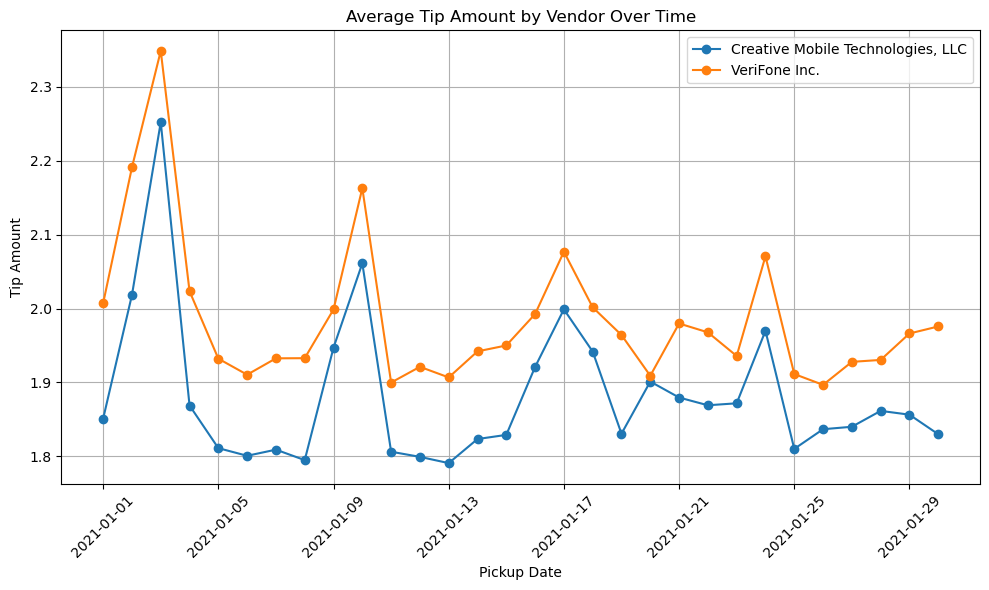

In [11]:
# Step 1: Read the CSV file
df = pd.read_csv(q1_output_path)

# Step 2: Convert 'pickup_date' to datetime format
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

# Step 3: Plot the data
plt.figure(figsize=(10, 6))

# Plot for VendorId 0
vendor0 = df[df['VendorID'] == 1.0]
plt.plot(vendor0['pickup_date'], vendor0['tip_amount'], label='Creative Mobile Technologies, LLC', marker='o')

# Plot for VendorId 1
vendor1 = df[df['VendorID'] == 2.0]
plt.plot(vendor1['pickup_date'], vendor1['tip_amount'], label='VeriFone Inc.', marker='o')

plt.title('Average Tip Amount by Vendor Over Time')
plt.xlabel('Pickup Date')
plt.ylabel('Tip Amount')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Which time of the day is the busiest?
To find the busiest time of the day, we have considered these reasonings and assumptions:

### Reasoning:
- **Extract Time**: We're interested in the busiest time of the day, so we need to focus on the hour of the day when trips occur. Extracting the hour from the datetime column allows us to group rides by the hour they started.
- **Group by Hour**: This step is crucial because we want to find the busiest hour. Grouping by the extracted hour ensures that we count the number of trips for each hour separately.
- **Count Trips**: Counting the number of trips for each hour gives us the volume of rides, which we use to determine the busiest time.

### Assumptions:
- **Consistent Data**: It assumes that the data is consistent and that `tpep_pickup_datetime` accurately reflects when trips start. Inaccurate or missing data could affect the results.
- **Single Time Zone**: The function assumes that all data is in the same time zone. If the dataset spans multiple time zones, the busiest hour might vary by location.

In [12]:
def find_busiest_time_of_day(data):
    # Convert 'tpep_pickup_datetime' to datetime and extract the hour
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
    
    # Group by 'pickup_hour' and count the number of trips
    busiest_time = data.groupby('pickup_hour').size().reset_index(name='trip_count')
    
    # Find the hour with the maximum number of trips
    # busiest_time = busiest_time[busiest_time['trip_count'] == busiest_time['trip_count'].max()]
    
    return busiest_time

In [13]:
trip_data_df_copy = trip_data_df.copy()
busiest_time_df = find_busiest_time_of_day(trip_data_df_copy)
busiest_time_df.to_csv(q2_output_path)

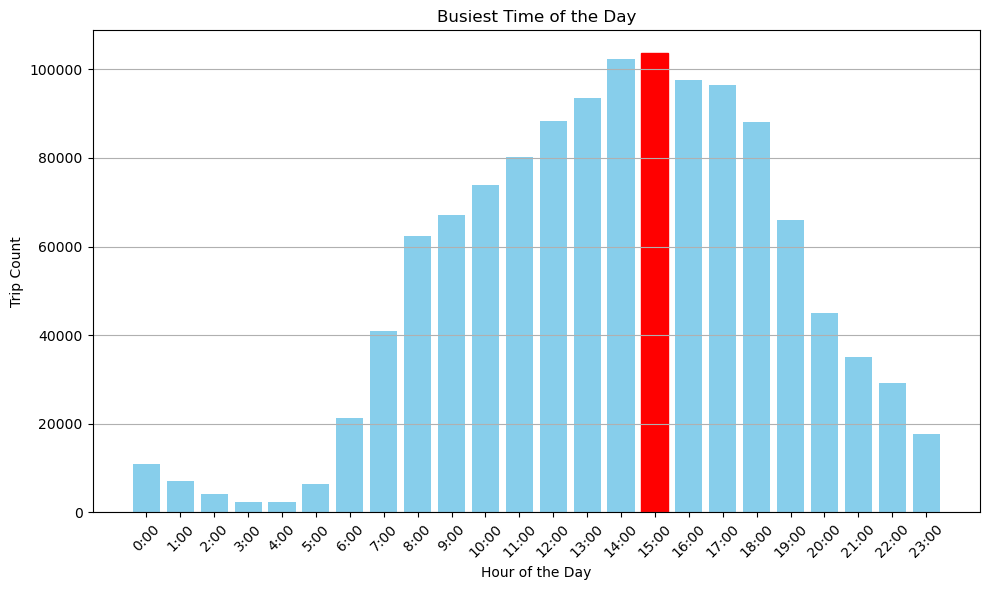

In [14]:
# Step 1: Read the CSV file
df = pd.read_csv(q2_output_path)

# Step 2: Plot the data
plt.figure(figsize=(10, 6))

# Plotting the trip count for each hour
bars = plt.bar(df['pickup_hour'], df['trip_count'], color='skyblue')

# Find the index of the maximum trip count
max_index = df['trip_count'].idxmax()

# Change the color of the bar with the maximum trip count to red
bars[max_index].set_color('red')

plt.title('Busiest Time of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Trip Count')
plt.xticks(range(24), labels=[f'{i}:00' for i in range(24)], rotation=45)
plt.grid(axis='y')
plt.tight_layout()

plt.show()

plt.show()

## Classify trips based on Payment Type
To handle cases with invalid payment types and use the `payment_type_mappings` dictionary for classification, we have considered these reasonings and assumptions:

### Reasoning:
- **Map Payment Types**: We use the `payment_type_mappings` to convert numeric payment types to descriptive labels. This makes the data more readable and allows for easier analysis. For invalid payment types, we assign "Unknown" to ensure that all trips are accounted for.
- **Classify Trips**: We're interested in the distribution of trips by payment type, so we group the data by the mapped `payment_type` column. This allows us to count the number of trips for each payment type separately.
- **Count Trips**: Counting the number of trips for each payment type gives us the volume of rides, which we use to determine the popularity of each payment method.


In [15]:
def classify_trips_by_payment_type_with_mappings(data, payment_type_mappings):
    # Map payment types using the provided mappings, assign 'Unknown' for invalid types
    data['payment_type'] = data['payment_type'].map(payment_type_mappings).fillna('Unknown Unknown')
    
    # Group by the mapped 'payment_type' and count the number of trips
    payment_type_counts = data.groupby('payment_type').size().reset_index(name='trip_count')
    
    return payment_type_counts

In [16]:
payment_type_mappings = {1: 'Credit Card', 2: 'Cash', 3: 'No charge', 4: 'Dispute', 5: 'Unknown', 6: 'Voided Trip'}
trip_data_df_copy = trip_data_df.copy()
classify_trips_df = classify_trips_by_payment_type_with_mappings(trip_data_df_copy, payment_type_mappings)
classify_trips_df.to_csv(q4_output_path)

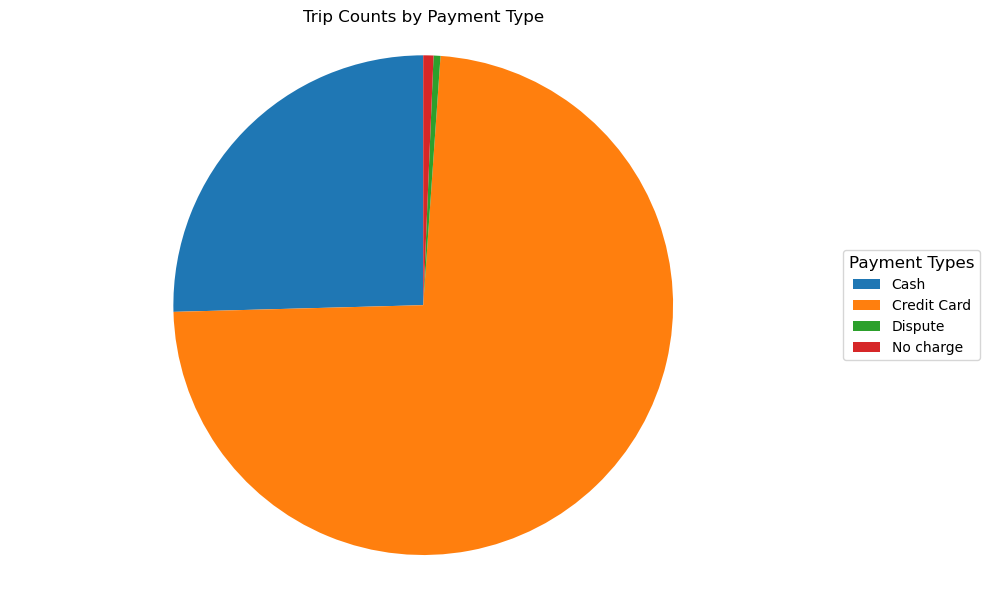

In [17]:
from matplotlib.patches import Patch

# Step 1: Read the CSV file
df = pd.read_csv(q4_output_path)

# Step 2: Plot the data
plt.figure(figsize=(10, 6))

# Define a color palette
colors = plt.cm.tab10.colors  # Example color palette

# Plotting the trip count for each payment type as a pie chart with specific colors
plt.pie(df['trip_count'], startangle=90, pctdistance=0.85, textprops={'fontsize': 8}, colors=colors[:len(df)])

# Creating a custom legend with color coding
legend_elements = [Patch(facecolor=colors[i], edgecolor='none', label=f"{label}") for i, label in enumerate(df['payment_type'])]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), title="Payment Types", title_fontsize='large', fontsize='medium')

plt.title('Trip Counts by Payment Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()

plt.show()

## Is there any relationship between congestion surcharge and trip distance?
To determine if there's a relationship between `congestion_surcharge` and `trip_distance`, we can perform a statistical analysis on the data. This involves calculating a correlation coefficient, which measures the strength and direction of the linear relationship between two variables. A positive correlation indicates that as one variable increases, the other also increases, while a negative correlation indicates that as one variable increases, the other decreases. A correlation coefficient close to 0 suggests no linear relationship.

### Interpretation of the Correlation Coefficient:

- **Positive Correlation (e.g., 0.5)**: Indicates that as `trip_distance` increases, `congestion_surcharge` also tends to increase. This could suggest that longer trips are more likely to incur higher congestion surcharges.
- **Negative Correlation (e.g., -0.3)**: Indicates that as `trip_distance` increases, `congestion_surcharge` tends to decrease. This could suggest that longer trips are less likely to incur higher congestion surcharges, possibly due to economies of scale or other factors.
- **Close to 0 (e.g., 0.05)**: Indicates no linear relationship between `trip_distance` and `congestion_surcharge`. This means that changes in one variable do not have a consistent effect on the other.

### Additional Considerations:

- **Outliers**: Outliers can significantly affect the correlation coefficient. It's a good practice to check for outliers in both `congestion_surcharge` and `trip_distance` before calculating the correlation.
- **Non-linear Relationships**: The correlation coefficient measures linear relationships. If the relationship between `congestion_surcharge` and `trip_distance` is non-linear, the correlation coefficient might not fully capture the relationship.

In [18]:
merged_df = pd.merge(left=trip_data_df, right=surcharge_df, on='tripId')
merged_df.to_csv(q5_output_path)

In [19]:
# Calculate the correlation coefficient
correlation_coefficient = merged_df['congestion_surcharge'].corr(merged_df['trip_distance'])

print(f"Correlation coefficient between congestion_surcharge and trip_distance: {correlation_coefficient}")

Correlation coefficient between congestion_surcharge and trip_distance: -0.22518738895538623


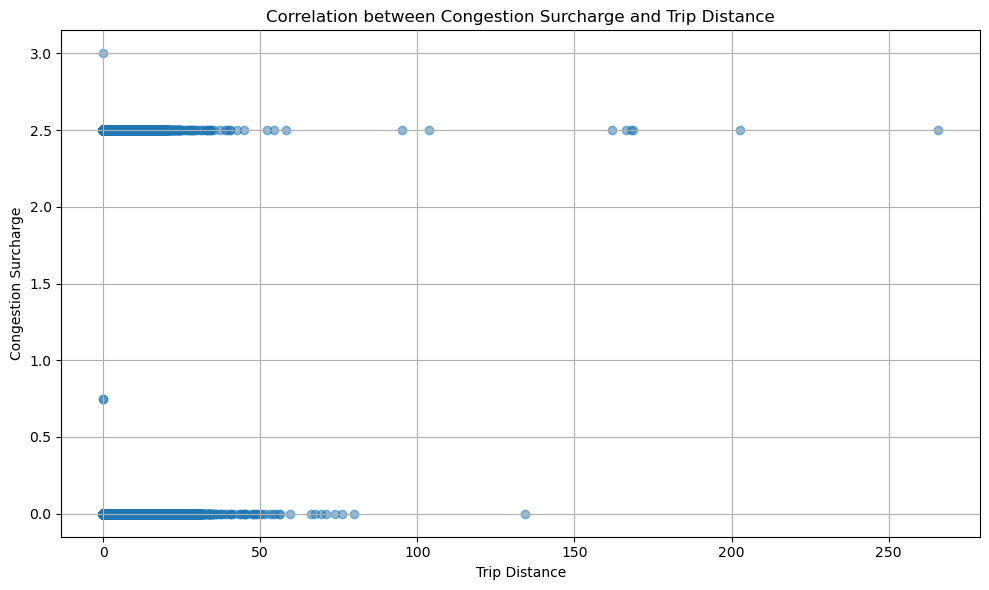

In [20]:
# Step 1: Read the CSV file
df = pd.read_csv('temp.csv')

# Step 2: Plot the data
plt.figure(figsize=(10, 6))

# Plotting the correlation between congestion_surcharge and trip_distance
plt.scatter(df['trip_distance'], df['congestion_surcharge'], alpha=0.5)

plt.title('Correlation between Congestion Surcharge and Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Congestion Surcharge')
plt.grid(True)
plt.tight_layout()

plt.show()